# Equivalent layer technique for estimating total magnetization direction using airborne survey

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
import datetime
import timeit
import string as st

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_magdirection_RM.ipynb'

#### Importing auxiliary functions

In [4]:
dir_modules = '../../../mypackage'
sys.path.append(dir_modules)

In [5]:
import auxiliary_functions as fc

#### Loading properties of the model

In [6]:
with open('data/model_multi.pickle') as f:
        model_multi = pickle.load(f)

#### Loading properties grid

In [7]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [8]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Loading results

In [9]:
with open('data/result_RM_airb.pickle') as f:
        results = pickle.load(f)

### Saving files

In [10]:
saved_files = []

## Observation area

In [11]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 5000.0 m 
 x_min = -5000.0 m 
 y_max = 5000.0 m 
 y_min = -5000.0 m


### airborne survey information

In [12]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (60,21)
Number of data: 1260.0
dx: 169.5 m
dy: 500.0 m 


## Properties of the model

### Main field

In [13]:
inc_gf,dec_gf = model_multi['main_field']

In [14]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: -20.0 degree
Main field declination: -20.0 degree


### Magnetization direction

In [15]:
print 'Inclination: %.1f degree' % model_multi['inc_R1']
print 'Declination: %.1f degree' % model_multi['dec_R1']

Inclination: -60.0 degree
Declination: 30.0 degree


In [16]:
inc_R,dec_R = model_multi['inc_R1'],model_multi['dec_R1']

### Coordinates equivalent sources

In [17]:
h = results['layer_depth']

In [18]:
shape_layer = (airborne['shape'][0],airborne['shape'][1])

In [19]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Results after L-curve

In [20]:
m_LM = results['magnetic_moment'][1]
inc_est = results['inc_est'][1]
dec_est = results['dec_est'][1]

In [21]:
mu = results['reg_parameter'][1]

In [22]:
phi = results['phi'][1]

In [23]:
print mu

1000.0


### Visualization of the convergence

In [24]:
phi = (np.array(phi)/airborne['x'].size)

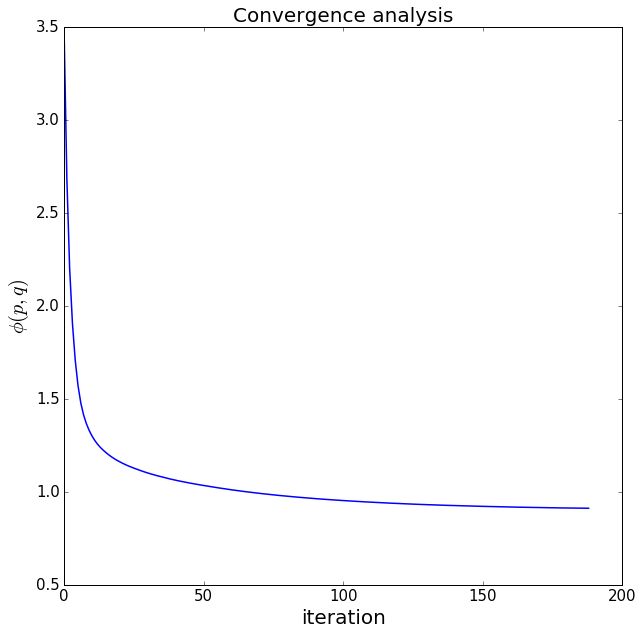

In [25]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b-',linewidth=1.5)


plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi (p,q)$', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/airborne/convergence_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Estimated magnetization direction

In [26]:
print (inc_est,dec_est)

(-35.960840155425579, -23.478289780792796)


In [27]:
print (inc_R,dec_R)

(-60.0, 30.0)


### Comparison between observed data and predicted data

In [28]:
pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [29]:
res = pred - data['tfa_obs_RM_airb']

In [30]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_RM_airb'],pred)

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


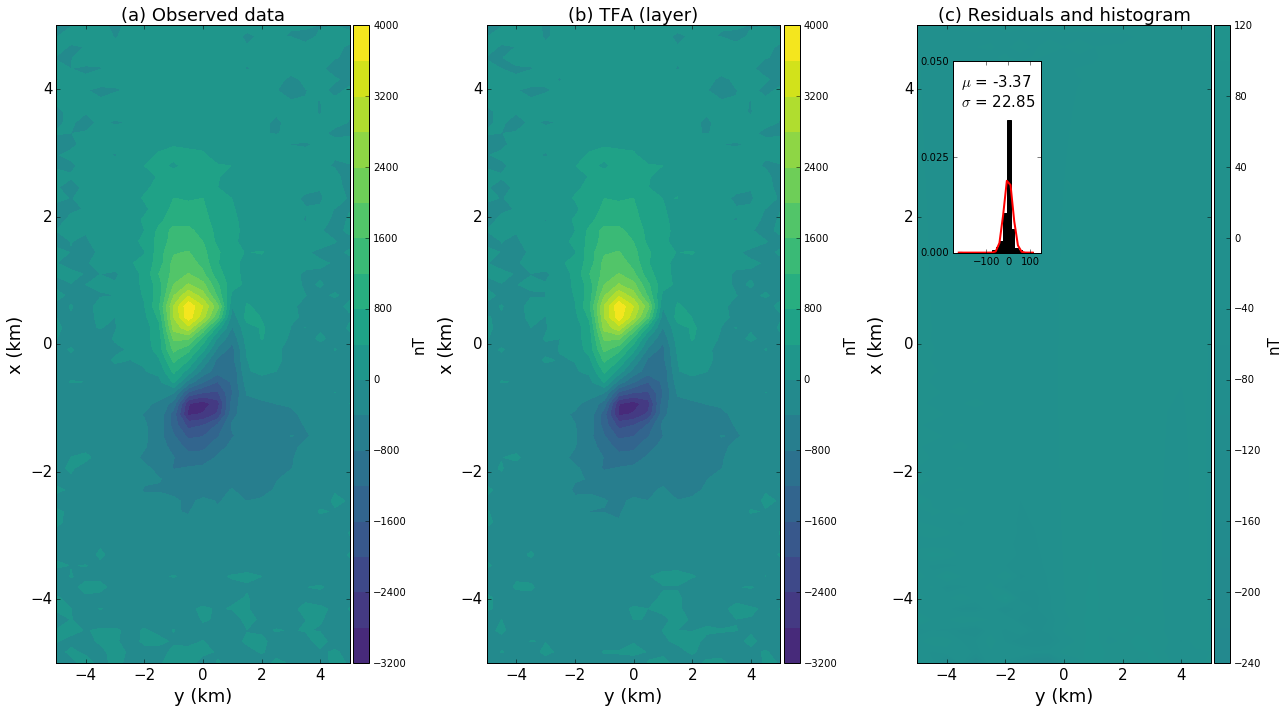

In [31]:
title_font = 18
bottom_font = 15
plt.figure(figsize=(18,10), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_RM_airb'].max(), 
                                   data['tfa_obs_RM_airb'].min(),
                                   pred.max(), pred.min()]).max()
## Observed data plot
ax1=plt.subplot(1,3,1)

plt.title('(a) Observed data', fontsize=title_font)
plt.xlabel('y (km)',fontsize = title_font)
plt.ylabel('x (km)',fontsize = title_font)
plt.contourf(1e-3*airborne['y'].reshape(airborne['shape']),
             1e-3*airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_RM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.tick_params(axis='both', which='major', labelsize=bottom_font)

## Predicted data plot
ax2=plt.subplot(1,3,2)

plt.title('(b) TFA (layer)', fontsize=title_font)
plt.xlabel('y (km)',fontsize = title_font)
plt.ylabel('x (km)',fontsize = title_font)
plt.contourf(1e-3*airborne['y'].reshape(airborne['shape']),
             1e-3*airborne['x'].reshape(airborne['shape']),
             pred.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.tick_params(axis='both', which='major', labelsize=bottom_font)

## Residuals plot and histogram
ax3=plt.subplot(1,3,3)

plt.title('(c) Residuals and histogram', fontsize=title_font)
plt.xlabel('y (km)',fontsize = title_font)
plt.ylabel('x (km)',fontsize = title_font)
plt.contourf(1e-3*airborne['y'].reshape(airborne['shape']),
             1e-3*airborne['x'].reshape(airborne['shape']),
             res.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.tick_params(axis='both', which='major', labelsize=bottom_font)

subax3 = inset_axes(ax3, width="30%", height="30%", loc=2, borderpad=3.)
plt.text(0.15, 0.93, "$\mu$ = {:.2f}\n$\sigma$ = {:.2f}".format(np.mean(res), np.std(res)),
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax3.transAxes, fontsize=15)
nbins = 20
n, bins, patches = plt.hist(res,bins=nbins, normed=True, color='black')
gauss = mlab.normpdf(bins, 0., 20.)
plt.plot(bins, gauss, 'r-', linewidth=2.)
subax3.set_xticks([-100.0,0.0,100.0])
subax3.set_yticks([0.0,.025,0.05])

## 
file_name = 'figs/airborne/data_fitting_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

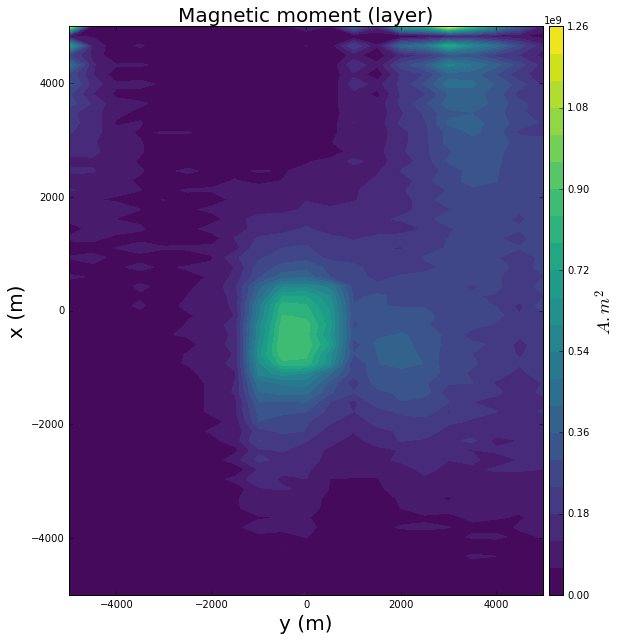

In [32]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer), 20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)

file_name = 'figs/airborne/magnetic_moment_positive_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')


plt.show()

### Reduction to the pole

In [33]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [34]:
tfa_rtp = np.dot(G_rtp,m_LM)

#### Visualization of a reduction to the pole

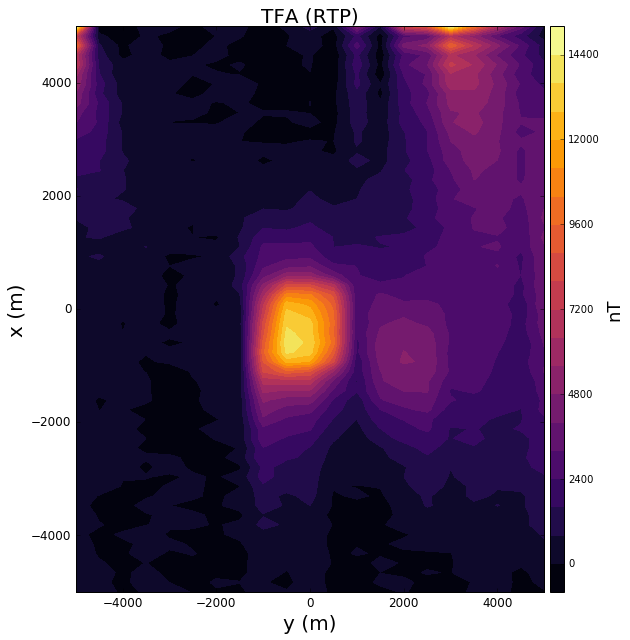

In [35]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_airborne_magRM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

# Visualization of the RTP and Magnetic moment over the layer

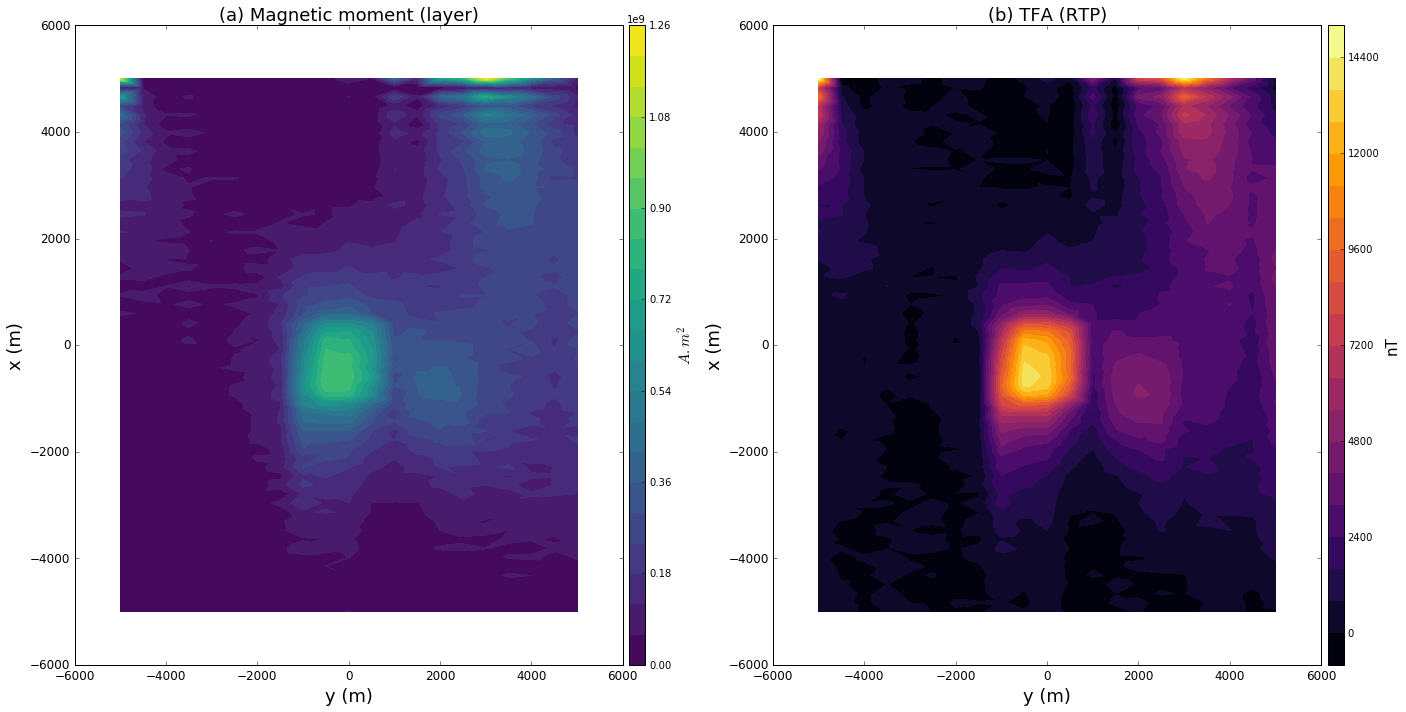

In [36]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(20,10), tight_layout=True)

plt.subplot(1,2,1)
plt.tricontourf(ys,xs,m_LM,20,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,2,2)
plt.tricontourf(airborne['y'],airborne['x'], tfa_rtp, 20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_moment_LM_NNLS_RM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()